In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [3]:
image = cv2.imread('/home/shawn/OMSCS6476/ps02-master/input_images/scene_all_signs.png')
output = image.copy()
image1 = image.copy()
image2 = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#b,g,r = cv2.split(image)       # get b,g,r
#rgb_img = cv2.merge([r,g,b])     # switch it to rgb

In [4]:
def get_lines(lines_in):
    if cv2.__version__ < '3.0':
        return lines_in[0]
    return [l[0] for l in lines_in]

In [5]:
def lineMagnitude (x1, y1, x2, y2):
    lineMagnitude = math.sqrt(math.pow((x2 - x1), 2)+ math.pow((y2 - y1), 2))
    return lineMagnitude

In [6]:
def DistancePointLine(px, py, x1, y1, x2, y2):
    ix = lineMagnitude(px, py, x1, y1)
    iy = lineMagnitude(px, py, x2, y2)
    return min(ix, iy)

In [7]:
def get_distance(line1, line2):
    dist1 = DistancePointLine(line1[0][0], line1[0][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist2 = DistancePointLine(line1[1][0], line1[1][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist3 = DistancePointLine(line2[0][0], line2[0][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])
    dist4 = DistancePointLine(line2[1][0], line2[1][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])


    return min(dist1,dist2,dist3,dist4)

In [8]:
def group_lines(lines):
    super_lines = []
    min_distance_to_merge = 20
    lines = sorted(lines, key= lambda _line:_line[0][0])
    
    for idx1, line in enumerate(lines):
        create_new_group = True
        group_updated = False

        for group in super_lines:
            for line3 in group:
                if (1 <= get_distance(line3, line) and get_distance(line3, line) <= min_distance_to_merge):
                    group.append(line)
                    create_new_group = False
                    group_updated = True
                    break
            if group_updated:
                break
        
        #create new group is lines are not close enough
        if (create_new_group):
            new_group = []
            new_group.append(line)
            for idx2, line2 in enumerate(lines):
                # check the distance between lines
                if (1 <= get_distance(line2, line) <= min_distance_to_merge):
                    new_group.append(line2)
            # append new group
            super_lines.append(new_group)

    return super_lines

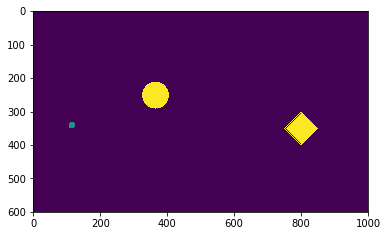

In [9]:
hsv_img = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
#lower mask
lower_orange_on = np.array([30,50,50])
upper_orange_on = np.array([40,255,255])
mask_orange_on = cv2.inRange(hsv_img, lower_orange_on, upper_orange_on)

mask_orange_on  = cv2.bitwise_and(image1,image1, mask= mask_orange_on )
mask_orange_on  = cv2.cvtColor(mask_orange_on , cv2.COLOR_BGR2GRAY)
cv2.imwrite('mask_orange_on.png', mask_orange_on)

plt.imshow(mask_orange_on )
plt.show()

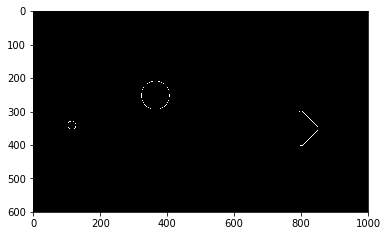

In [10]:
#blur=((3,3),1)
#erode_=(5,5)
#dilate_=(5, 5)


#kernel = np.ones((5,5), np.float32)/15
kernel = np.ones((7,7),np.uint8)
#gray = cv2.dilate(cv2.erode(cv2.GaussianBlur(mask_red_on/50,blur[0],blur[1]),np.ones(erode_)),np.ones(dilate_))*255
gray = cv2.filter2D(mask_orange_on,-1,kernel)

#kernel = np.ones((5,5),np.uint8)
gray = cv2.erode(gray,kernel,iterations=1)

gray = cv2.dilate(gray, np.ones((5,5)))

#dst = cv2.fastNlMeansDenoisingColored(image1,None,20,50,7,21)
#gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

laplacian = cv2.Laplacian(gray,cv2.CV_64F)
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
edges = cv2.Canny(gray,50,250,apertureSize=5)

cv2.imwrite('edges.png', edges)

plt.imshow(edges, cmap='gray')
plt.show()

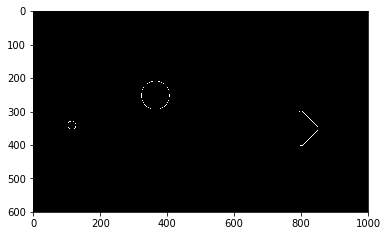

(4,
 4,
 [[748, 352, 797, 401],
  [802, 298, 851, 346],
  [748, 347, 797, 298],
  [804, 401, 851, 354]])

In [11]:
edges = cv2.Canny(gray,50,250,apertureSize=5)

plt.imshow(edges,cmap = 'gray')
plt.show()

lines = cv2.HoughLinesP(edges,0.5,np.pi/180, threshold = 20,minLineLength = 20,maxLineGap = 20)[0].tolist()

#lines = cv2.HoughLinesP(edges,1,np.pi/180,275, minLineLength = 600, maxLineGap = 100)[0].tolist()


for index1, (x1,y1,x2,y2) in enumerate(lines):
    for index2, (x3,y3,x4,y4) in enumerate(lines):
        if index1!=index2 and y1-20<=y3<=y1+20 and y2-20<=y4<= y2+20 and x1-20<=x3<=x1+20 and x2-20<=x4<=x2+20: # Horizontal Lines
            del lines[index2]

"""
_lines = []
for _line in lines:
    _lines.append([(_line[0], _line[1]),(_line[2], _line[3])])

gp_lines = group_lines(_lines)

for i in range(np.shape(gp_lines)[0]):
    for index1, line1 in enumerate(gp_lines[i]):
        for index2, line2 in enumerate(gp_lines[i]):
            if index1!=index2 and line1[0][0]-5<=line2[0][0]<=line1[0][0]+5 and line1[0][1]-5<=line2[0][1]<= line1[0][1]+5: # Horizontal Lines
                del gp_lines[i][index2]
"""
N = np.shape(lines)[0]
M = np.shape(lines)[1]
#N = lines.shape[0]
#M = lines[0].shape[0]
N,M, lines

#N, M, lines


In [13]:
# find center
center_x = None
center_y = None
state = ''
max_x = 0
min_x = 1000
max_y = 0
min_y = 1000

if (N == 4):
    state = 'warning'

for i in range(N):    
    x1 = lines[i][0]
    y1 = lines[i][1]    
    x2 = lines[i][2]
    y2 = lines[i][3]    
    max_x = max(max_x, x1, x2)
    max_y = max(max_y, y1, y2)
    min_x = min(min_x, x1, x2)
    min_y = min(min_y, y1, y2)

    
    
    
center_x = np.int((max_x + min_x)/2.0)
center_y = np.int((max_y + min_y)/2.0)
        
center_x, center_y, state

(851, 748, 401, 298, 799, 349, 'warning')

In [787]:
circles = cv2.HoughCircles(edges, cv2.cv.CV_HOUGH_GRADIENT, 0.5, 100, param1=50, param2=20,minRadius=10, maxRadius=30)[0].tolist()
circles = np.round(circles).astype("int")
print(circles)

[[234 334  29]]


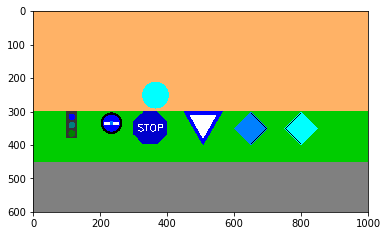

In [788]:
for (x, y, r) in circles:
    # draw the circle in the output image, then draw a rectangle
    # corresponding to the center of the circle
    #if ((center_x - 10 <= x <= center_x + 10)  & (center_r - 10 <= r <= center_r + 10)): 
    cv2.circle(output, (x, y), r, (0, 0, 0), 6)
    cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1) 
cv2.imwrite('all.png', output)
plt.imshow(output)
plt.show()

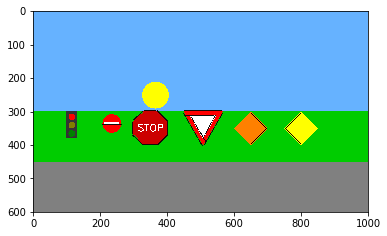

In [725]:
for i in range(N):
    x1 = lines[i][0]
    y1 = lines[i][1]    
    x2 = lines[i][2]
    y2 = lines[i][3]    
    cv2.line(image1,(x1,y1),(x2,y2),(10,10,20),2)
        

b,g,r = cv2.split(image1)       # get b,g,r
img = cv2.merge([r,g,b]) 

cv2.imwrite('output1.png', image1)

plt.imshow(img)
plt.show()


In [797]:
# find center
length = np.shape(gp_lines)[0]
center_x = None
center_y = None
dictionary = {}
state = ''
count = 0
for i in range(length):
    if (len(gp_lines[i]) == 6):
        state = 'yield'
        for index1, [[x1, y1], [x2, y2]] in enumerate(gp_lines[i]):
            for index2, [[x3, y3], [x4, y4]] in enumerate(gp_lines[i]):
                if(y1==y2 and y3==y4 and y1 < y3):        
                    center_x = np.int(math.fabs(x2+x1)/2)
                    center_y = np.int(y1 + (math.fabs(x2-x1)*math.cos(math.pi/6) - (math.fabs(x2-x1)/2)/math.cos(math.pi/6)))
        dictionary[state]=(center_x, center_y)
    if(len(gp_lines[i]) == 8):
        state = 'stop'
        max_x = 0
        min_x = 1000
        max_y = 0
        min_y = 1000
        for [[x1,y1],[x2,y2]] in gp_lines[i]:       
            max_x = max(max_x, x1, x2)
            max_y = max(max_y, y1, y2)
            min_x = min(min_x, x1, x2)
            min_y = min(min_y, y1, y2)
        center_x = np.int((max_x + min_x)/2.0)
        center_y = np.int((max_y + min_y)/2.0)
        dictionary[state]=(center_x, center_y)

dictionary['no_entry'] = (circles[0][0],circles[0][1])
        
dictionary

{'no_entry': (234, 334), 'stop': (348, 348), 'yield': (507, 328)}

In [11]:
# find center
center_x = None
center_y = None
state = ''
count = 0

if (M == 3 or M == 6):
    state = 'yield'

for i in range(N):
    for j in range(M):
        x1 = lines[i][j][0]
        y1 = lines[i][j][1]    
        x2 = lines[i][j][2]
        y2 = lines[i][j][3]    
        if  (y2 - 5 <= y1 <= y2 + 5):
            center_x = np.int(math.fabs(x2+x1)/2)
            center_y = np.int(y1 + (math.fabs(x2-x1)*math.cos(math.pi/6) - (math.fabs(x2-x1)/2)/math.cos(math.pi/6)))

center_x, center_y, state


(307, 182, 'yield')

In [12]:
cv2.rectangle(output, (center_x - 5, center_y - 5), (center_x + 5, center_y + 5), (0, 128, 255), -1)  


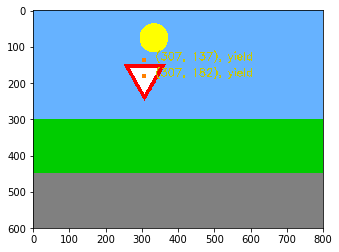

In [13]:
                      
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (center_x + 30,center_y)
fontScale              = 1
fontColor              = (0,200,200)
lineType               = 2
 
cv2.putText(output,('(%s, %s), %s'%(center_x, center_y, state)), 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
output_img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output_img)
plt.show()

In [6]:
def findGroup(lines):
    M = lines.shape[0]
    for i in range(M):
        x1 = lines[i][0]
        y1 = lines[i][1]    
        x2 = lines[i][2]
        y2 = lines[i][3] 
        


In [ ]:
lines = cv2.HoughLinesP(edges,1,np.pi/180,275, minLineLength = 600, maxLineGap = 100)[0].tolist()

for x1,y1,x2,y2 in lines:
    for index, (x3,y3,x4,y4) in enumerate(lines):

        if y1==y2 and y3==y4: # Horizontal Lines
            diff = abs(y1-y3)
        elif x1==x2 and x3==x4: # Vertical Lines
            diff = abs(x1-x3)
        else:
            diff = 0

        if diff < 10 and diff is not 0:
            del lines[index]

gridsize = (len(lines) - 2) / 2

In [ ]:
def lines_close(line1, line2):
    dist1 = math.hypot(line1[0][0] - line2[0][0], line1[0][1] - line2[0][1])
    dist2 = math.hypot(line1[0][2] - line2[0][0], line1[0][3] - line2[0][1])
    dist3 = math.hypot(line1[0][0] - line2[0][2], line1[0][1] - line2[0][3])
    dist4 = math.hypot(line1[0][2] - line2[0][2], line1[0][3] - line2[0][3])

    if (min(dist1,dist2,dist3,dist4) < 40):
        return True
    else:
        return False

In [37]:
kernel = np.ones((5,5), np.float32)/25
gray = cv2.filter2D(gray,-1,kernel)
#image1 = cv2.filter2D(image1, -1, kernel)
#image2 = 

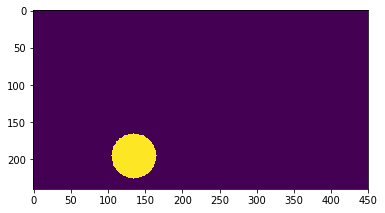

In [38]:
#define the state of the traffic light
#hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_img = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
#lower mask
lower_red_on = np.array([0,50,150])
upper_red_on = np.array([10,255,255])
mask_red_on_0 = cv2.inRange(hsv_img, lower_red_on, upper_red_on)
#upper mask
lower_red_on = np.array([170,50,150])
upper_red_on = np.array([180,255,255])
mask_red_on_1 = cv2.inRange(hsv_img, lower_red_on, upper_red_on)
mask_red_on = mask_red_on_1 + mask_red_on_0
mask_red_on = cv2.bitwise_and(image1,image1, mask= mask_red_on)
mask_red_on = cv2.cvtColor(mask_red_on, cv2.COLOR_BGR2GRAY)
# define range of blue color in HSV
lower_yellow_on = np.array([20,50,150])
upper_yellow_on = np.array([40,255,255])
mask_yellow_on = cv2.inRange(hsv_img, lower_yellow_on, upper_yellow_on)
mask_yellow_on = cv2.bitwise_and(image1,image1, mask= mask_yellow_on)
mask_yellow_on = cv2.cvtColor(mask_yellow_on, cv2.COLOR_BGR2GRAY)
#mask_yellow_on = mask_yellow_on[:,:,2]
# define range of blue color in HSV
lower_green_on = np.array([50,50,150])
upper_green_on = np.array([70,255,255])
mask_green_on = cv2.inRange(hsv_img, lower_green_on, upper_green_on)
mask_green_on = cv2.bitwise_and(image1,image1, mask= mask_green_on)
mask_green_on = cv2.cvtColor(mask_green_on, cv2.COLOR_BGR2GRAY)
#mask_green_on = mask_green_on[:,:,2]
#cv2.imwrite('output2.jpg', mask_green)
plt.imshow(mask_green_on)
plt.show()

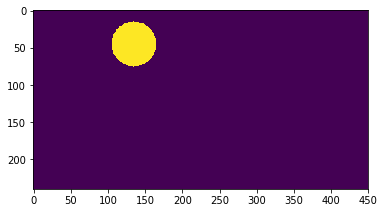

In [39]:
#Traffic light or not
hsv_img = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
#lower mask
lower_red_all = np.array([0,50,50])
upper_red_all = np.array([10,255,255])
mask_red_all_0 = cv2.inRange(hsv_img, lower_red_all, upper_red_all)
#upper mask
lower_red_all = np.array([170,50,50])
upper_red_all = np.array([180,255,255])
mask_red_all_1 = cv2.inRange(hsv_img, lower_red_all, upper_red_all)
mask_red_all = mask_red_all_1 + mask_red_all_0
mask_red_all = cv2.bitwise_and(image1,image1, mask= mask_red_all)
mask_red_all = cv2.cvtColor(mask_red_all, cv2.COLOR_BGR2GRAY)
# define range of yellow color in HSV
lower_yellow_all = np.array([20,50,50])
upper_yellow_all = np.array([40,255,255])
mask_yellow_all = cv2.inRange(hsv_img, lower_yellow_all, upper_yellow_all)
mask_yellow_all = cv2.bitwise_and(image1,image1, mask= mask_yellow_all)
mask_yellow_all = cv2.cvtColor(mask_yellow_all, cv2.COLOR_BGR2GRAY)
# define range of green color in HSV
lower_green_all = np.array([50,50,50])
upper_green_all = np.array([70,255,255])
mask_green_all = cv2.inRange(hsv_img, lower_green_all, upper_green_all)
mask_green_all = cv2.bitwise_and(image1,image1, mask= mask_green_all)
mask_green_all = cv2.cvtColor(mask_green_all, cv2.COLOR_BGR2GRAY)
#cv2.imwrite('output2.jpg', mask_green)
plt.imshow(mask_red_all)
plt.show()

In [40]:
>>> #green = np.uint8([[[0,255,0 ]]])
>>> #hsv_green = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)
>>> #print hsv_green

In [41]:
#target color to HSV
#yellow_color=np.uint8([[[255,255,0]]])
#yellow_color_hsv = cv2.cvtColor(yellow_color, cv2.COLOR_BGR2HSV)
#plt.imshow(yellow_color_hsv)
#plt.show()

In [42]:
# find circles
circles_red_on = cv2.HoughCircles(mask_red_on, cv2.cv.CV_HOUGH_GRADIENT, 1, 50, param1=30, param2=10,minRadius=3, maxRadius=30)
print(circles_red_on)
circles_yellow_on = cv2.HoughCircles(mask_yellow_on, cv2.cv.CV_HOUGH_GRADIENT, 1, 50, param1=30, param2=10,minRadius=3, maxRadius=30)
print(circles_yellow_on)
circles_green_on = cv2.HoughCircles(mask_green_on, cv2.cv.CV_HOUGH_GRADIENT, 1, 50, param1=30, param2=10,minRadius=3, maxRadius=30)
print(circles_green_on)
circles_red_all = cv2.HoughCircles(mask_red_all, cv2.cv.CV_HOUGH_GRADIENT, 1, 50, param1=30, param2=10,minRadius=3, maxRadius=30)
print(circles_red_all)
circles_yellow_all = cv2.HoughCircles(mask_yellow_all, cv2.cv.CV_HOUGH_GRADIENT, 1, 50, param1=30, param2=10,minRadius=3, maxRadius=30)
print(circles_yellow_all)
circles_green_all = cv2.HoughCircles(mask_green_all, cv2.cv.CV_HOUGH_GRADIENT, 1, 50, param1=30, param2=10,minRadius=3, maxRadius=30)
print(circles_green_all)

None
None
[[[ 133.5         192.5          27.32215309]]]
[[[ 133.5          42.5          27.32215309]]]
[[[ 133.5         117.5          27.32215309]]]
[[[ 133.5         192.5          27.32215309]]]


In [43]:
#determine if it is a traffic light
center_x = None
center_y = None
center_r = None

if (circles_red_all is not None) & (circles_yellow_all is not None) & (circles_green_all is not None) :
    circles_red = np.round(circles_red_all[0, :]).astype("int")
    circles_yellow = np.round(circles_yellow_all[0, :]).astype("int")
    circles_green = np.round(circles_green_all[0, :]).astype("int")
    for (rd_x, rd_y, rd_r) in circles_red:
        for(yl_x, yl_y, yl_r) in circles_yellow:
            for(gr_x, gr_y, gr_r) in circles_green:
                #if (yl_x - 5 <= rd_x <= yl_x + 5) & (gr_x - 5 <= rd_x <= gr_x + 5) & (gr_y < yl_y < rd_y) & (yl_y-gr_y -5 <=rd_y-yl_y <= yl_y-gr_y+5):
                #if rd_x in (yl_x - 5,yl_x + 5) & rd_x in (gr_x - 5, gr_x + 5) & yl_y in (gr_y, rd_y) & rd_y-yl_y in (yl_y-gr_y -5, yl_y-gr_y+5):
                if ((yl_x - 5 <= rd_x <= yl_x + 5) & (gr_x - 5 <= rd_x <= gr_x + 5) & (gr_y > yl_y > rd_y) & (gr_y - yl_y -10 <= yl_y - rd_y <= gr_y - yl_y + 10)) :
                    center_x = yl_x
                    center_y = yl_y
                    center_r = yl_r

center_x, center_y, center_r

(134, 118, 27)

In [44]:
#determine tl state
state = None

if circles_red_on is not None:
    circles_red_on = np.round(circles_red_on[0, :]).astype("int")
    for(x, y, r) in circles_red_on:
        if (center_r - 5<= r <= center_r + 5):
            state = 'red'

if circles_green_on is not None:
    circles_green_on = np.round(circles_green_on[0, :]).astype("int")
    for(x, y, r) in circles_green_on:
        if (center_r - 5<= r <= center_r + 5):
            state = 'green'
            
if circles_yellow_on  is not None:
    circles_yellow_on = np.round(circles_yellow_on[0, :]).astype("int")
    for(x, y, r) in circles_yellow_on:
        if (center_r - 5 <= r <= center_r + 5):
            state = 'yellow'

(center_x, center_y),state
print(circles_green_on)

[[134 192  27]]


In [45]:
if state == 'red':
    # convert the (x, y) coordinates and radius of the circles to integers
    #circles_red_on = np.round(circles_red_on[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles_red_on:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        if (center_x - 10 <= x <= center_x + 10  & center_r - 10 <= r <= center_r + 10): 
            cv2.circle(output, (x, y), r, (0, 255, 0), 4)
            cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

if state == 'yellow':
    # convert the (x, y) coordinates and radius of the circles to integers
    #circles_yellow_on = np.round(circles_yellow_on[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles_yellow_on:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        if (center_x - 10 <= x <= center_x + 10  & center_r - 10 <= r <= center_r + 10): 
            cv2.circle(output, (x, y), r, (0, 255, 0), 4)
            cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
            
if state == 'green':
    # convert the (x, y) coordinates and radius of the circles to integers
    #circles_green_on = np.round(circles_green_on[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles_green_on:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        if ((center_x - 10 <= x <= center_x + 10)  & (center_r - 10 <= r <= center_r + 10)): 
            cv2.circle(output, (x, y), r, (0, 255, 0), 4)
            cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)            
    # show the output image
    #cv2.imshow("output", np.hstack([image, output]))
    #cv2.waitKey(0)
    
    



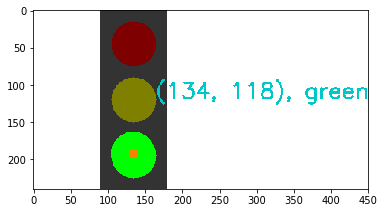

In [48]:
b,g,r = cv2.split(output)       # get b,g,r
output_img = cv2.merge([r,g,b])     # switch it to rgb	
img=np.hstack([rgb_img, output_img])
                         
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (center_x + 30,center_y)
fontScale              = 1
fontColor              = (0,200,200)
lineType               = 2
 
cv2.putText(output_img,('(%s, %s), %s'%(center_x, center_y, state)), 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)

plt.imshow(output_img)
plt.show()